We're going to first try training a CNN on the individual images.
We will be using binary cross entropy across the 17 regions.

In [1]:
import HelperFuncs as hfuncs
import numpy as np
from sklearn.model_selection import train_test_split
from keras.utils.data_utils import Sequence
import h5py
import os
import gc 

gc.collect()

BATCH_SIZE = 1
FINAL_WIDTH = 400
FINAL_HEIGHT = 600
CHANNELS = 1
ZONES = 17
ANGLES = 16
#Create directories for sequencer function if they don't exist
for d in ['temp/train_scan/','temp/test_scan/','temp/val_scan/']:
    if not os.path.isdir(d):
        print("Created directory: {}".format(d))
        os.makedirs(d)
        
class ScanSequencer(Sequence):
    idx_dict={}
    
    def __init__(self,num_batches,bucket_name,mode="train_scan"):
        self.num_batches = num_batches
        self.bucket_name = bucket_name
        self.mode = mode
        self.key_id, self.secret_key = hfuncs.GetAWSCredentials()
        self.mode = mode
        self.angles = np.arange(0,64,64//ANGLES)
    def __len__(self):
        return self.num_batches
    def on_epoch_end(self):
        pass
    def __getitem__(self,idx):
        #Get Client
        client = hfuncs.GetAWSClient(self.key_id,self.secret_key)
        bucket = client.Bucket(self.bucket_name)
        
        #Initialize vectors
        X_train = np.zeros((BATCH_SIZE,ANGLES,FINAL_WIDTH,FINAL_HEIGHT,CHANNELS))
        y_train = np.zeros((BATCH_SIZE,ZONES))
        
        j=0
        for i in range(idx*BATCH_SIZE,(idx+1)*BATCH_SIZE):
            #Download batch at index
            path = "temp/{}/batch_{}.hdf5".format(self.mode,i)
            key = "{}/batch_{}.hdf5".format(self.mode,i)
            bucket.download_file(Key=key,Filename=path)
        
            f = h5py.File(path,"r")
            try:
                X_train[j,:,:,:,:] = f['/image'].value[self.angles,:,:,:]
                y_train[j,:] = f['/labels'].value
                j += 1
            finally:
                f.close()
                os.remove(path) 
        return X_train, y_train
class LegScanSequencer(Sequence):
    idx_dict={}
    
    def __init__(self,num_batches,bucket_name,mode="train_scan",batch_size=BATCH_SIZE):
        self.num_batches = num_batches
        self.bucket_name = bucket_name
        self.mode = mode
        self.key_id, self.secret_key = hfuncs.GetAWSCredentials()
        self.mode = mode
        self.angles = np.arange(0,64,64//ANGLES)
        self.batch_size = batch_size
    def __len__(self):
        return self.num_batches
    def on_epoch_end(self):
        pass
    def __getitem__(self,idx):
        #Get Client
        client = hfuncs.GetAWSClient(self.key_id,self.secret_key)
        bucket = client.Bucket(self.bucket_name)
        
        #Initialize vectors
        X_train = np.zeros((self.batch_size,ANGLES,FINAL_WIDTH,FINAL_HEIGHT*3//5,CHANNELS))
        y_train = np.zeros((self.batch_size,1))
        s_weights = np.zeros((self.batch_size))
        j=0
        for i in range(idx*self.batch_size,(idx+1)*self.batch_size):
            #Download batch at index
            path = "temp/{}/batch_{}.hdf5".format(self.mode,i)
            key = "{}/batch_{}.hdf5".format(self.mode,i)
            bucket.download_file(Key=key,Filename=path)
        
            f = h5py.File(path,"r")
            try:
                X_train[j,:,:,:,:] = f['/image'].value[self.angles,:,:FINAL_HEIGHT*3//5,:]
                r_leg = [7,8,9,10,11,12,13,14,15]
                l_leg = [13,15]
                r_y = np.amax(f['/labels'].value[r_leg])
                #l_y = np.amax(f['/labels'].value[l_leg])
                y_train[j,:] = r_y
                s_weights[j] =np.squeeze(r_y*0 + 1) #np.squeeze(r_y + (-1 * r_y + 1)*2)
                j += 1
            finally:
                f.close()
                os.remove(path) 
        return X_train, y_train,s_weights



Using TensorFlow backend.


In [2]:
from twilio.rest import Client
import configparser
from keras.callbacks import Callback

class SMSNotifier(Callback):
    def on_epoch_end(self,epoch,logs=None):
        #Execute every other epoch
        if epoch % 2 == 0:
            #Get config credentials
            config = configparser.ConfigParser()
            config.read('twilio.conf')
            account_sid = config['DEFAULT']['AccountID']
            auth_token = config['DEFAULT']['AuthToken']
            #Get client
            client = Client(account_sid, auth_token)
            #Create message
            if logs is not None:
                message = "Epoch {} complete. Loss: {} Val_loss: {} ".format(epoch,
                                                                             logs.get('loss'),
                                                                             logs.get('val_loss'))
            else:
                message = "Epoch {} complete. No loss data available.".format(epoch)
            #Sendmessage
            message = client.messages.create(
                to="+16178884129", 
                from_="+18572142288",
                body=message)
        else:
            pass

In [3]:
#Build pre-trained V2 model
import numpy as np
from keras.layers import Input,Flatten,Dense,Concatenate,Dropout,concatenate,GlobalMaxPool2D,GlobalAveragePooling1D
from keras.models import Model
from datetime import datetime
from keras.callbacks import TensorBoard,EarlyStopping,ModelCheckpoint,ReduceLROnPlateau
from keras.optimizers import Adam,Adadelta,SGD
from keras.metrics import binary_accuracy
from keras.layers.wrappers import TimeDistributed
from keras.layers.recurrent import GRU
from keras.losses import binary_crossentropy
from keras.applications.inception_v3 import InceptionV3,preprocess_input
from keras.layers.core import Lambda
import tensorflow as tf
from keras import backend as K
from keras.initializers import RandomUniform,glorot_uniform
#from keras.applications.vgg19 import VGG19

#K.set_learning_phase(1)
def ToRGB(x):
    max_v = tf.reduce_max(x)
    min_v = tf.reduce_min(x)
    max_rgb = tf.constant(255,dtype=x.dtype)
    min_rgb = tf.constant(255//2,dtype=x.dtype)
    x = tf.add(tf.floordiv(tf.multiply(tf.subtract(x,min_v),tf.subtract(max_rgb,min_rgb)),tf.subtract(max_v,min_v)),min_rgb)
    return x
def ToGreyScale(x):
    #Divide RGB into 3
   # scalar = tf.constant(3,dtype=x.dtype)
    #x = tf.floordiv(x,scalar)
    shape = x.get_shape()
    #assume channel_last
    mult = [[1 for d in shape[:-1]],[3]]
    mult = [val for sublist in mult for val in sublist]
    return tf.tile(x,mult)
def ToNewShape(x):
    ndim = len(x.shape)
    if ndim == 5:
        return tf.reverse(tf.transpose(x,[0,1,3,2,4]),[-3])
    elif ndim == 4:
        return tf.reverse(tf.transpose(x,[0,2,1,3]),[-3])
    else:
        raise ValueError("Unexpected number of dims!")
def PrintActivation(x):
    meanv = tf.reduce_mean(x)
    minv = tf.reduce_min(x)
    maxv = tf.reduce_max(x)
    #print('Mean:{},Min:{},Max:{}'.format(meanv.eval(),minv.eval(),maxv.eval()))
    return [meanv,minv,maxv]
def getSingleLegModel(lstm_dim=100):
    #Single model image
    input_img = Input(shape=(FINAL_WIDTH,FINAL_HEIGHT*3//5,CHANNELS))
    
    #preprocess and extract channels
    input_img_pp = Lambda(ToRGB)(input_img)
    input_img_pp = Lambda(ToGreyScale)(input_img_pp)
    input_img_pp = Lambda(preprocess_input)(input_img_pp)
    input_img_pp = Lambda(ToNewShape)(input_img_pp)
    
    #Load resnet
    incep = InceptionV3(include_top=False,
                          weights='imagenet',
                          input_tensor=None,
                          input_shape=(FINAL_HEIGHT*3//5,FINAL_WIDTH,3),
                          pooling='None')
    for l in incep.layers:
        l.trainable=False

    #Take off top
    reduced_net = Model(incep.input,incep.get_layer('mixed5').output)
    #print(reduced_net.uses_learning_phase)
    output = reduced_net(input_img_pp)
   # output = Lambda(PrintActivation,name='PrintDist')(output)
    output = GlobalMaxPool2D()(output)
   # output = Lambda(PrintActivation,name='PrintDist2')(output)
    #dropout = Dropout(0.5)(output)
    #dense = Dense(100)(dropout)
    #output = Dense(20,kernel_initializer=glorot_uniform(seed=0))(output)
    #output = Lambda(PrintActivation,name='PrintDist3')(output)
    #dense = Dense(1,activation='sigmoid',use_bias=False,
     #            kernel_initializer=RandomUniform(minval=-0.5,
      #                                            maxval=0.5,seed=0))(output)
    #output = Lambda(PrintActivation,name='PrintDist3')(dense)
    intermediate_model = Model(input_img,output)
    #print(intermediate_model.uses_learning_phase)
    #Time distributed model
    input_scan = Input(shape=(ANGLES,FINAL_WIDTH,FINAL_HEIGHT*3//5,CHANNELS))
    sequenced_model = TimeDistributed(intermediate_model)(input_scan)
    #print(sequenced_model._uses_learning_phase)
    sequenced_model._uses_learning_phase = True
    #One GRU layer for now
    gru = GRU(lstm_dim,dropout=0.5,use_bias=False,
              kernel_initializer=glorot_uniform(seed=0))(sequenced_model)
    #Finally, 1 dense layers
    out = Dense(1,activation='sigmoid',use_bias=False,
                kernel_initializer=RandomUniform(minval=-0.5,maxval=0.5,seed=0))(gru)
    #complete model
    model = Model(input_scan,out)
    #print(model.uses_learning_phase)
    try:
        return model#Model(input_scan, out)
    finally:
        del incep #intermediate_model,sequenced_model,incep
        



In [4]:
#Tensorboard wrapper #https://github.com/fchollet/keras/issues/3358
class TensorBoardWrapper(TensorBoard):
    '''Sets the self.validation_data property for use with TensorBoard callback.'''

    def __init__(self, batch_gen, nb_steps, **kwargs):
        super().__init__(**kwargs)
        self.batch_gen = batch_gen # The generator.
        self.nb_steps = nb_steps     # Number of times to call next() on the generator.

    def on_epoch_end(self, epoch, logs):
        # Fill in the `validation_data` property. Obviously this is specific to how your generator works.
        # Below is an example that yields images and classification tags.
        # After it's filled in, the regular on_epoch_end method has access to the validation_data.
        X_val,y_val,w_val = None, None, None
        for s in range(self.nb_steps):
            X, y, w = self.batch_gen.__getitem__(s)
            if X_val is None and y_val is None and w_val is None:
                X_val = np.zeros((np.absolute(self.nb_steps * X.shape[0]), *X.shape[1:]))
                y_val = np.zeros((np.absolute(self.nb_steps * y.shape[0]), *y.shape[1:]))
                w_val = np.zeros((np.absolute(self.nb_steps * w.shape[0])))
            X_val[s * X.shape[0]:(s + 1) * X.shape[0]] = X
            y_val[s * y.shape[0]:(s + 1) * y.shape[0]] = y
            w_val[s * w.shape[0]:(s + 1) * w.shape[0]] = w
        self.validation_data = (X_val,y_val,w_val,0)
        return super().on_epoch_end(epoch, logs)

In [ ]:

rnn_model = getSingleLegModel()
print("Rnn Model Retrieved")

Rnn Model Retrieved


In [8]:
for l in rnn_model.layers:
    print(l.name, l.trainable,l.output_shape)
print()


input_3 False (None, 16, 400, 360, 1)
time_distributed_1 True (None, 16, 768)
gru_1 True (None, 100)
dense_1 True (None, 1)



In [ ]:
from keras.models import load_model
description = "Average_layer5"
#adad = Adadelta()
#print("Loading weights")
#average_model.load_weights("check_points/AverageModel_00-11.94.hdf5")
adam = Adam(lr=0.001,beta_1=0.9,beta_2=0.999)
#sgd = SGD(lr = 0.0001,momentum = 0.25,nesterov=True)
rnn_model.compile(optimizer=adam,
                          metrics=[binary_accuracy],
                         loss= binary_crossentropy,)


#Model checkpoint
x = datetime.today()
check_point_dir = 'check_points/'
if not os.path.isdir(check_point_dir):
    os.makedirs(check_point_dir)    
chkpt = ModelCheckpoint(os.path.join(check_point_dir,"TestAverageModel_{epoch:02d}-{val_loss:.2f}.hdf5"),
                       monitor='loss',
                       verbose=1,
                       save_best_only=True)
#Reduce learning rate on plateau
reduce_lr = ReduceLROnPlateau(monitor='loss',
                             factor=0.2,
                             patience=3,
                             verbose=1,
                             min_lr=0.00001,
                             cooldown = 5)
#Notifications
notify = SMSNotifier()

#Early stopping callback
estop = EarlyStopping(monitor='loss',min_delta=0.001,patience=25)

#Generators and fit
print("Initializing generators...")
#Bucket with clean data
UPLOAD_BUCKET = 'cleandhsdata' #bucket where clean data was stored
key_id, secret_key = hfuncs.GetAWSCredentials()
client = hfuncs.GetAWSClient(key_id,secret_key)
bucket = client.Bucket(UPLOAD_BUCKET)

#Initialize train sequencer
mode ="train_scan"
num_batches_train = (sum([1 if "{}/".format(mode) in k.key else 0 for k in bucket.objects.all()])-1)//BATCH_SIZE #train,test,val root directories have their own keys
#num_batches = 660//BATCH_SIZE
train_seq = LegScanSequencer(num_batches_train,UPLOAD_BUCKET,mode=mode)
#Initialize validation sequencer
mode = "val_scan"
num_batches_val = (sum([1 if "{}/".format(mode) in k.key else 0 for k in bucket.objects.all()])-1)//BATCH_SIZE #train,test,val root directories have their own keys
val_seq = LegScanSequencer(num_batches_val,UPLOAD_BUCKET,mode=mode)

#Tensorboard
stamp = "FullModelTest_layer5_0.001_v1"
tensorboard = TensorBoardWrapper(val_seq,nb_steps=5,log_dir="logs/{}".format(stamp),histogram_freq=1,batch_size=1,
                          write_grads=True,write_images=False,write_graph=False)
    

print("Beginning training...")
#recurrent_model.load_weights('check_points/2017_10_3_17_ScanModel_01-1.29.hdf5')

hist= rnn_model.fit_generator(train_seq,
                                   steps_per_epoch = num_batches_train,
                                   epochs = 500,
                                   validation_data = val_seq,
                                    validation_steps = 50,# num_batches_val,
                                   callbacks=[chkpt,tensorboard],#,estop,reduce_lr],
                                  use_multiprocessing = False,workers=1)


Initializing generators...
Beginning training...
Epoch 1/500


In [7]:
#Bucket with clean data
UPLOAD_BUCKET = 'cleandhsdata' #bucket where clean data was stored
key_id, secret_key = hfuncs.GetAWSCredentials()
client = hfuncs.GetAWSClient(key_id,secret_key)
bucket = client.Bucket(UPLOAD_BUCKET)

#Initialize train sequencer
mode ="train_scan"
num_batches_train = 25 #(sum([1 if "{}/".format(mode) in k.key else 0 for k in bucket.objects.all()])-1)//BATCH_SIZE #train,test,val root directories have their own keys
#num_batches = 660//BATCH_SIZE
train_seq = LegScanSequencer(num_batches_train,UPLOAD_BUCKET,mode=mode)
X,y,w =train_seq.__getitem__(14)
print(X.shape)
print(y,w)


(1, 16, 400, 360, 1)
[[ 1.]] [ 1.]


(1, 400, 360, 3)


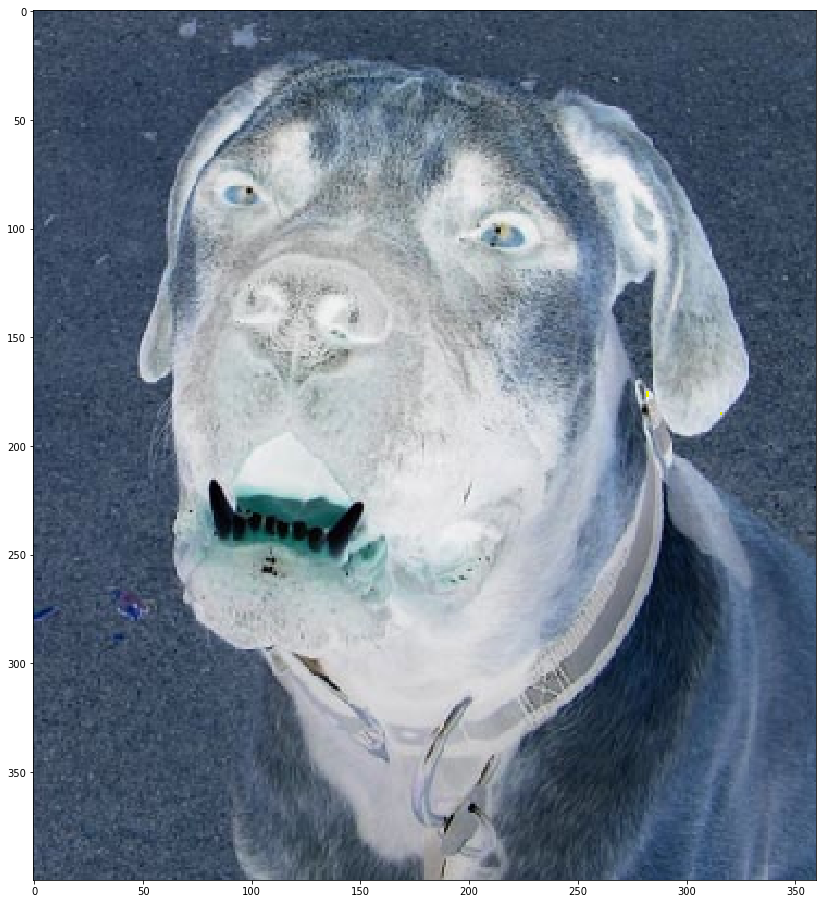

In [51]:
from keras.preprocessing.image import load_img,img_to_array
from matplotlib import pyplot as plt 
%matplotlib inline
import seaborn as sns

img = load_img('individualImage.png',grayscale=False,target_size=(FINAL_WIDTH,FINAL_HEIGHT*3//5))
img_ary = np.array([img_to_array(img)])
print(img_ary.shape)
fig = plt.figure(figsize = (16,16))
ax = fig.add_subplot(111)
ax.imshow(img_ary[0])#, cmap = 'viridis')



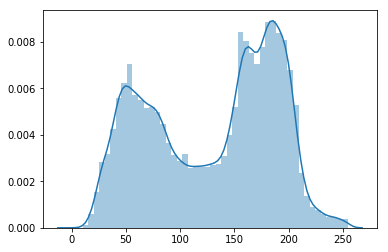

In [35]:
sns.distplot(img_ary.flatten())

In [5]:
#Test modelchanges
sess = tf.InteractiveSession()
slm = getSingleLegModel()






In [8]:
result = slm.predict(X)
print(result)


[[ 0.84323871]]


In [ ]:
fig = plt.figure(figsize = (16,16))
ax = fig.add_subplot(111)
ax.imshow(result[0,1,:,:,:])#, cmap = 'viridis')


In [ ]:
#Test how many positive samples
import pickle
labels = hfuncs.GetLabelsDict(r'stage1_labels.csv')
#filename = "data_separated.pickle"
#with open(filename,"rb") as f:
#   save = pickle.load(f)
#   K_test= save['K_test']
#   K_val = save['K_val']
#   K_train = save['K_train']
#s = 0
#pos = 0
s= 0
pos = 0
for k_clean in labels.keys():
    label = np.array(labels[k_clean])
    val = np.amax(label[[7,8,9,10,11,12,13,14,15]])
    if val == 1:
        s += 1
        pos += 1
    else:
        s += 1
print("total={},pos={}".format(s,pos))

In [ ]:
710/1147